In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from src.tables_old import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, get_tables, get_tbl_info, table_to_df, get_tbl_timespan
from src.preprocess import preprocess
from src.utils import  time_utc_now, np_min_chunk, df_na_vals, reduce_mem_usage
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import warnings

# Filter out all warnings related to pandas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
from src.manager import DbManager

dbm = DbManager('../data/vast.db')
# dbm = DbManager('../vast.db')

dbm.connect()
ts = dbm.table_to_df('ts_idx').timestamp
dbm.close()

sec = pd.to_datetime(ts * 1e9).diff().dt.seconds
# sec.describe()

sec

0        NaN
1       56.0
2       53.0
3       53.0
4       53.0
        ... 
1323    60.0
1324    54.0
1325    53.0
1326    53.0
1327    55.0
Name: timestamp, Length: 1328, dtype: float64

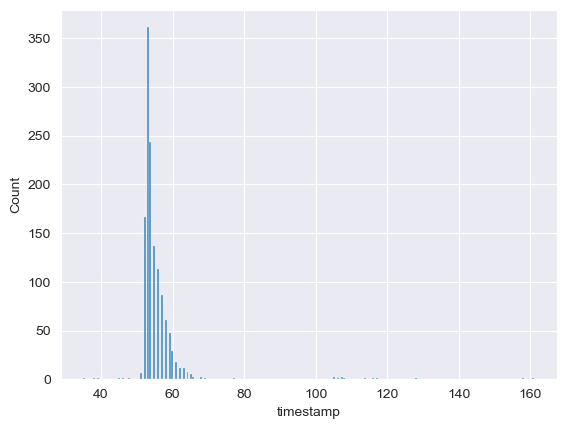

In [5]:
import seaborn as sns
sns.histplot(sec);

In [3]:
from src.utils import round_base
df = get_machines()

In [2]:
import sqlite3
import os
import pandas as pd
from src.manager import DbManager

db_path = '../data/vast.db'
# db_path = '../vast.db'

dbm = DbManager(db_path)
dbm.connect()
timespan = dbm.get_tbl_timespan('ts_idx')
total_days = timespan.total_seconds() / (3600 * 24)

print('Timespan:', timespan)

dbm.execute('VACUUM')
size = os.path.getsize(db_path) / (1024 * 1024) # Size in Mb

try:
    print(f'Size: {size: .2f} mb')
    print(f'Size per day: {size / total_days: .2f} mb')
    print(f'Size per year: {size / total_days * 365: .0f} mb')
except:
    pass

dbm.close()

Timespan: 1 days 20:07:26
Size:  19.86 mb
Size per day:  10.80 mb
Size per year:  3943 mb


In [11]:
dbm.connect()
ts = [x[0] for x in dbm.execute('SELECT DISTINCT timestamp FROM avg_snp').fetchall()]
pd.to_datetime(pd.Series(ts), unit='s')

0     2023-10-21 00:00:50
1     2023-10-21 00:01:46
2     2023-10-21 00:02:39
3     2023-10-21 00:03:33
4     2023-10-21 00:04:27
              ...        
208   2023-10-21 03:08:24
209   2023-10-21 03:09:17
210   2023-10-21 03:10:09
211   2023-10-21 03:11:02
212   2023-10-21 03:11:56
Length: 213, dtype: datetime64[ns]

In [13]:
dbm.execute('SELECT DISTINCT timestamp FROM avg_ts').fetchall()

[(1697699070,), (1697760000,), (1697846400,)]

In [25]:
import math
period = pd.to_timedelta('1 day').total_seconds()
end = int(math.ceil(dbm.get_last_ts('avg_snp') / period) * period)
print(pd.to_datetime(end, unit='s'), end)

2023-10-22 00:00:00 1697932800


In [17]:
pd.to_datetime(dbm.table_to_df('avg_ts').timestamp.unique(), unit='s')

DatetimeIndex(['2023-10-19 07:04:30', '2023-10-20 00:00:00',
               '2023-10-21 00:00:00'],
              dtype='datetime64[ns]', freq=None)

In [111]:
from src.manager import DbManager
dbm = DbManager(db_path)
dbm.connect()
dbm.get_db_stats()

,name,pages,size,percentage
0,total,19431,75.90,100.00
1,reliability_ts,12681,49.54,65.26
2,rent_ts,2441,9.54,12.56
3,cost_ts,1239,4.84,6.38
4,avg_ts,1113,4.35,5.73
5,eod_ts,834,3.26,4.29
6,disk_ts,673,2.63,3.46
7,timestamp_tbl,96,0.38,0.49
8,hardware_ts,93,0.36,0.48
9,hardware_snp,55,0.21,0.28


In [112]:
dbm.get_tbl_timespan('timestamp_tbl')

Timedelta('33 days 11:21:17')

In [113]:
df = dbm.table_to_df('timestamp_tbl')

In [114]:
df.timestamp.diff().describe()

count    38694.000000
mean        74.742260
std         36.997593
min         49.000000
25%         52.000000
50%         54.000000
75%        103.000000
max       3471.000000
Name: timestamp, dtype: float64

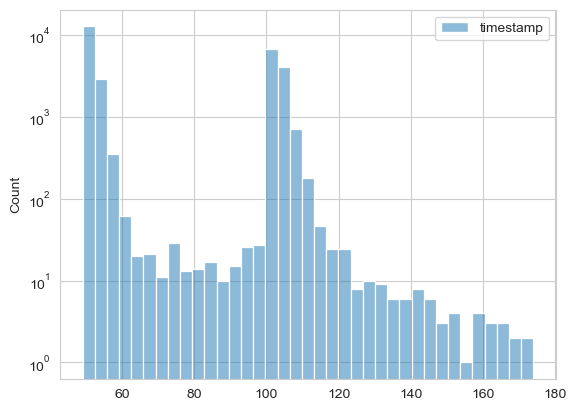

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df.diff().query('timestamp < 200'))
plt.yscale('log');

In [19]:
dbm.disconnect()

In [40]:
df.groupby('machine_id')['disk_bw'].resample('1D').mean().round().astype(np.uint16).reset_index().to_sql('disk_bw_avg', conn, if_exists='replace', index=False)

4553

In [41]:
df.groupby('machine_id')['disk_bw'].resample('1D').std().fillna(0).astype(np.uint16).reset_index().to_sql('disk_bw_std', conn, if_exists='replace', index=False)

4553

In [115]:
conn.close()

In [23]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=100000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")


    # Generate and insert values within the specified range
    values = None
    if 'INTEGER' in data_type:
        values = np.random.randint(*value_range, size=size, dtype=np.uint32)
    elif 'REAL' in data_type:
        values = np.random.uniform(*value_range, size=size).astype(np.float32)
    else:
        raise ValueError('Unknown type')        
        
    rows = [(value,) for value in values]
    
    
    try:
        # print(rows[:3])
        # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)

        for value in values:
            conn.execute(f"INSERT INTO data (value) VALUES ({value})")

        conn.commit()  
        conn.execute("VACUUM")    
    
    except Exception as e:
        print(e)
    
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 300))  
# create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 1))            
# create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 1000))            
# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024)  # Size in KB
    print(f"Database '{db_name}' size: {db_size:.2f} KB")

Database 'integer_db.sqlite' size: 932.00 KB
Database 'real_db.sqlite' size: 1564.00 KB


In [48]:
import os
import psutil

In [49]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.0
